# 1: Librerie
Importazione di tutte le librerie necessarie per la gestione del dataset, la costruzione del modello e l'apprendimento della rete.

* `tensorflow`: Funzioni di creazione del modello, e di gestione della fase di training.
* `numpy`: Gestione di array e funzioni di calcolo.
* `pandas`: Funzioni di apertura e parsing del dataset.
* `matplotlib`: Funzioni di gestione dei grafici, per la visualizzazione dei risultati in fase di training.

In [227]:
"""
Install dependencies:
>>> pip install --update pip
>>> pip install numpy pandas matplotlib seaborn scikit-learn tensorflow 
"""

'\nInstall dependencies:\n>>> pip install --update pip\n>>> pip install numpy pandas matplotlib seaborn scikit-learn tensorflow \n'

In [228]:
import tensorflow.keras.optimizers as optimizers
import tensorflow.keras.layers     as layers
import tensorflow.keras.models     as models
import pandas                      as pd
import numpy                       as np
import matplotlib.pyplot           as plt
import tensorflow                  as tf
import tensorflow.keras.backend    as K

from tensorflow.keras.callbacks            import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from sklearn.model_selection               import train_test_split
from sklearn.preprocessing                 import LabelEncoder as le
from sklearn.metrics                       import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight            import compute_class_weight
from tensorflow.keras                      import regularizers 
from tensorflow.keras.optimizers.schedules import LearningRateSchedule

## Variabili globali
* `num_layers`: Configurazione degli strati della rete. Aggiungendo e rimuovendo neuroni, è possibile modificare la rete.
    * Ogni elemento di `num_layers` dovrebbe essere un array di 3 elementi: numero di neuroni nello strato, funzione di attivazione, larghezza del dropout.
* `num_epochs`: Numero di epoche di training del modello.
* `batch_size`: Larghezza dei batch durante la fase di training.

In [229]:
net_layers = [
    [64, 'relu', 0.2]  +
    [32, 'relu', 0.1]  +
    [32, 'relu', 0.1]
]
num_epochs = 100 # Number of epochs
batch_size = 32  # Batch size

# 1. Loss Function Focal Loss

In [230]:
def focal_loss(gamma, alpha):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * K.log(y_pred)
        weight = alpha * K.pow(1 - y_pred, gamma)
        loss = weight * cross_entropy
        return K.sum(loss, axis=1)
    return focal_loss_fixed

# 2: Dataset augmentation function


In [231]:
def dataset_augmentation(dataset: pd.DataFrame, target_count = 1890, column_augmentation = ['Age', 'Old']) -> pd.DataFrame:

    col_key     = column_augmentation[0] # key column for filtering
    col_val     = column_augmentation[1] # value to filter by
    old_samples = dataset[dataset[col_key] == col_val].copy() # filter samples
    
    # check if there are any samples to augment
    if len(old_samples) == 0:
        print(f"WARNING: No samples found for {col_val} in column {col_key} for data augmentation.")
        return dataset
    
    # check if the number of samples is already sufficient
    if len(old_samples) >= target_count:
        print(f"WARNING: Number of samples for {col_val} in column {col_key} is already sufficient.")
        return dataset
    
    print(f"Target number of values for {col_val}: {target_count}")
    print(f"Number of samples found: {len(old_samples)}")

    num_cols = old_samples.keys()[1 : -1] # skip first and last column (not numeric features)
    
    synthetic_samples = []
    samples_needed    = target_count - len(old_samples)
    
    for i in range(samples_needed):

        base_sample = old_samples.sample(n = 1).iloc[0].copy() # base sample from 'Old' samples
        
        for col in num_cols: # add noise to numeric columns
            noise_factor     = np.random.uniform(0, 0.1)
            noise            = np.random.normal(0, base_sample[col] * noise_factor)
            base_sample[col] = max(0, base_sample[col] + noise) # ensure no negative values
        
        synthetic_samples.append(base_sample) # append modified sample to list
    
    # convert list of synthetic samples to DataFrame
    synthetic_df      = pd.DataFrame(synthetic_samples)
    augmented_dataset = pd.concat([dataset, synthetic_df], ignore_index = True)
    
    print(f"Number of samples after augmentation: {len(augmented_dataset)}")
    
    return augmented_dataset # return augmented dataset with synthetic samples

# 3: Dataset
Importazione del dataset e divisione delle istanze per validation, training e testing.

## Obiettivo del modello
Classificazione dell'età di un *abalone*, a seconda delle misure fisiche effettuate.

* Elementi: **4177** istanze, **5641** dopo  l'augmentation
* Features disponibili: **8** colonne
* Classificazione: **3** classi

In [232]:
try:

    dataset = pd.read_csv("./Shuffled_Dataset.csv") # load the dataset
    dataset['Sex'] = le().fit_transform(dataset['Sex']) # label encoding for column 'Sex'
    
    for val in dataset['Age'].unique(): # Dataset augmentation
        dataset = dataset_augmentation(dataset, target_count = 1890, column_augmentation = ['Age', val]) 

    # One-hot encoding for column 'Age'
    column     = 'Age'
    dataset    = pd.get_dummies(dataset, columns = [column], prefix = column)
    dummy_cols = [col for col in dataset.columns if col.startswith(f'{column}_')]

    # Separate features and labels
    Y = dataset[dummy_cols]
    X = dataset.drop(columns = dummy_cols)

    # First split: 70% train, 30% combined validation and test
    X_train, X_comb, Y_train, Y_comb = train_test_split(X, Y, test_size = 0.3, random_state = 42)

    # Second split: 65% validation, 35% test from the combined set
    X_val, X_test, Y_val, Y_test = train_test_split(X_comb, Y_comb, test_size = 0.35, random_state = 42)

    print("\nTraining set shape:  ", X_train.shape, Y_train.shape)
    print("Validation set shape:", X_val.shape, Y_val.shape)
    print("Test set shape:      ", X_test.shape, Y_test.shape)
    y_integers = np.argmax(Y_train.values, axis=1)
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_integers), y=y_integers)
    class_weight_dict = dict(enumerate(class_weights))
    print("Class weights:", class_weight_dict)
    
except FileNotFoundError:
    print("ERROR: Dataset file not found. Please ensure the file 'Dataset.csv' is in the current directory.")

Target number of values for Old: 1890
Number of samples found: 459
Number of samples after augmentation: 6031

Training set shape:   (4221, 8) (4221, 3)
Validation set shape: (1176, 8) (1176, 3)
Test set shape:       (634, 8) (634, 3)
Class weights: {0: np.float64(0.9777623349548298), 1: np.float64(1.0523560209424083), 2: np.float64(0.9737024221453288)}


# 4: Creazione del modello
Generazione di un modello di rete neurale.

In [237]:
model = models.Sequential([layers.Input(shape = (X_train.shape[1],))])  # Input layer
regularizer = regularizers.l2(0.01)

for layer in net_layers:
    model.add(layers.Dense(
        layer[0],
        activation=layer[1],
        kernel_regularizer=regularizer,        # regularizzazione sui pesi
        bias_regularizer=regularizer  


    ))
    model.add(layers.Dropout(layer[2]))          # Dropout layer
    model.add(layers.BatchNormalization())       # Batch normalization layer

    
model.add(layers.Dense(Y_train.shape[1], activation = 'softmax')) # Output layer

model.summary() # Print the model summary

Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_66 (Dense)                │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,027 (4.01 KB)

 Trainable params: 899 (3.51 KB)

 Non-trainable params: 128 (512.00 B)

## 5: Compilazione e training del modello generato

In [238]:
class CustomExponentialDecay(LearningRateSchedule):
    def __init__(self, initial_lr, decay_steps, decay_rate, min_lr):
        self.initial_lr = initial_lr
        self.decay_steps = decay_steps
        self.decay_rate = decay_rate
        self.min_lr = min_lr

    def __call__(self, step):
        lr = self.initial_lr * (self.decay_rate ** (step / self.decay_steps))
        return tf.maximum(lr, self.min_lr)

lr_schedule = CustomExponentialDecay(
    initial_lr = 0.001, # Starting learning rate
    decay_steps           = 101*5, # Number of steps before decay
    decay_rate            = 0.7, # Multiplicative decay factor
    min_lr  = 0.00025 # Minimum learning rate
)

model.compile(
    optimizer = optimizers.Adam(learning_rate = lr_schedule),
    loss      = focal_loss(gamma = 2, alpha = 0.25), 
    metrics   = ['accuracy', 'Precision', 'Recall']
)

early_stop = EarlyStopping(
    monitor              = 'val_loss',
    patience             = 19,
    restore_best_weights = True,
    min_delta            = 0.0001,
    verbose              = 1,
    start_from_epoch=50
 )


In [239]:
history = model.fit(
    X_train, Y_train,
    epochs=num_epochs,
    shuffle=True,
    batch_size=batch_size,
    validation_data=(X_val, Y_val),
    callbacks=[early_stop],
    class_weight=class_weight_dict 
)

Epoch 1/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - Precision: 0.5924 - Recall: 0.4088 - accuracy: 0.5361 - loss: 0.2490 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.4711 - val_loss: 0.1616
Epoch 2/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - Precision: 0.6919 - Recall: 0.4484 - accuracy: 0.6221 - loss: 0.1414 - val_Precision: 1.0000 - val_Recall: 0.0179 - val_accuracy: 0.5264 - val_loss: 0.1269
Epoch 3/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Precision: 0.7815 - Recall: 0.5277 - accuracy: 0.6992 - loss: 0.0955 - val_Precision: 0.8982 - val_Recall: 0.1726 - val_accuracy: 0.6565 - val_loss: 0.1053
Epoch 4/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Precision: 0.8053 - Recall: 0.5812 - accuracy: 0.7341 - loss: 0.0784 - val_Precision: 0.8901 - val_Recall: 0.2687 - val_accuracy: 0.7611 - val_loss: 0.0834
Epoch 5/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Precision: 0.8193 - Recall: 0.6121 - accuracy: 0.7579 - loss: 0.0683 - val_Precision: 0.8664 

## 6: Visualizzazione dei risultati

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Precision: 0.8455 - Recall: 0.8070 - accuracy: 0.8234 - loss: 0.0449 
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Test set evaluation:
Precision: 0.8531
Recall:    0.8060
Loss:      0.0403
Accuracy:  0.8312
F1-score:  0.8289


/tmp/ipykernel_891569/660950290.py:188: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


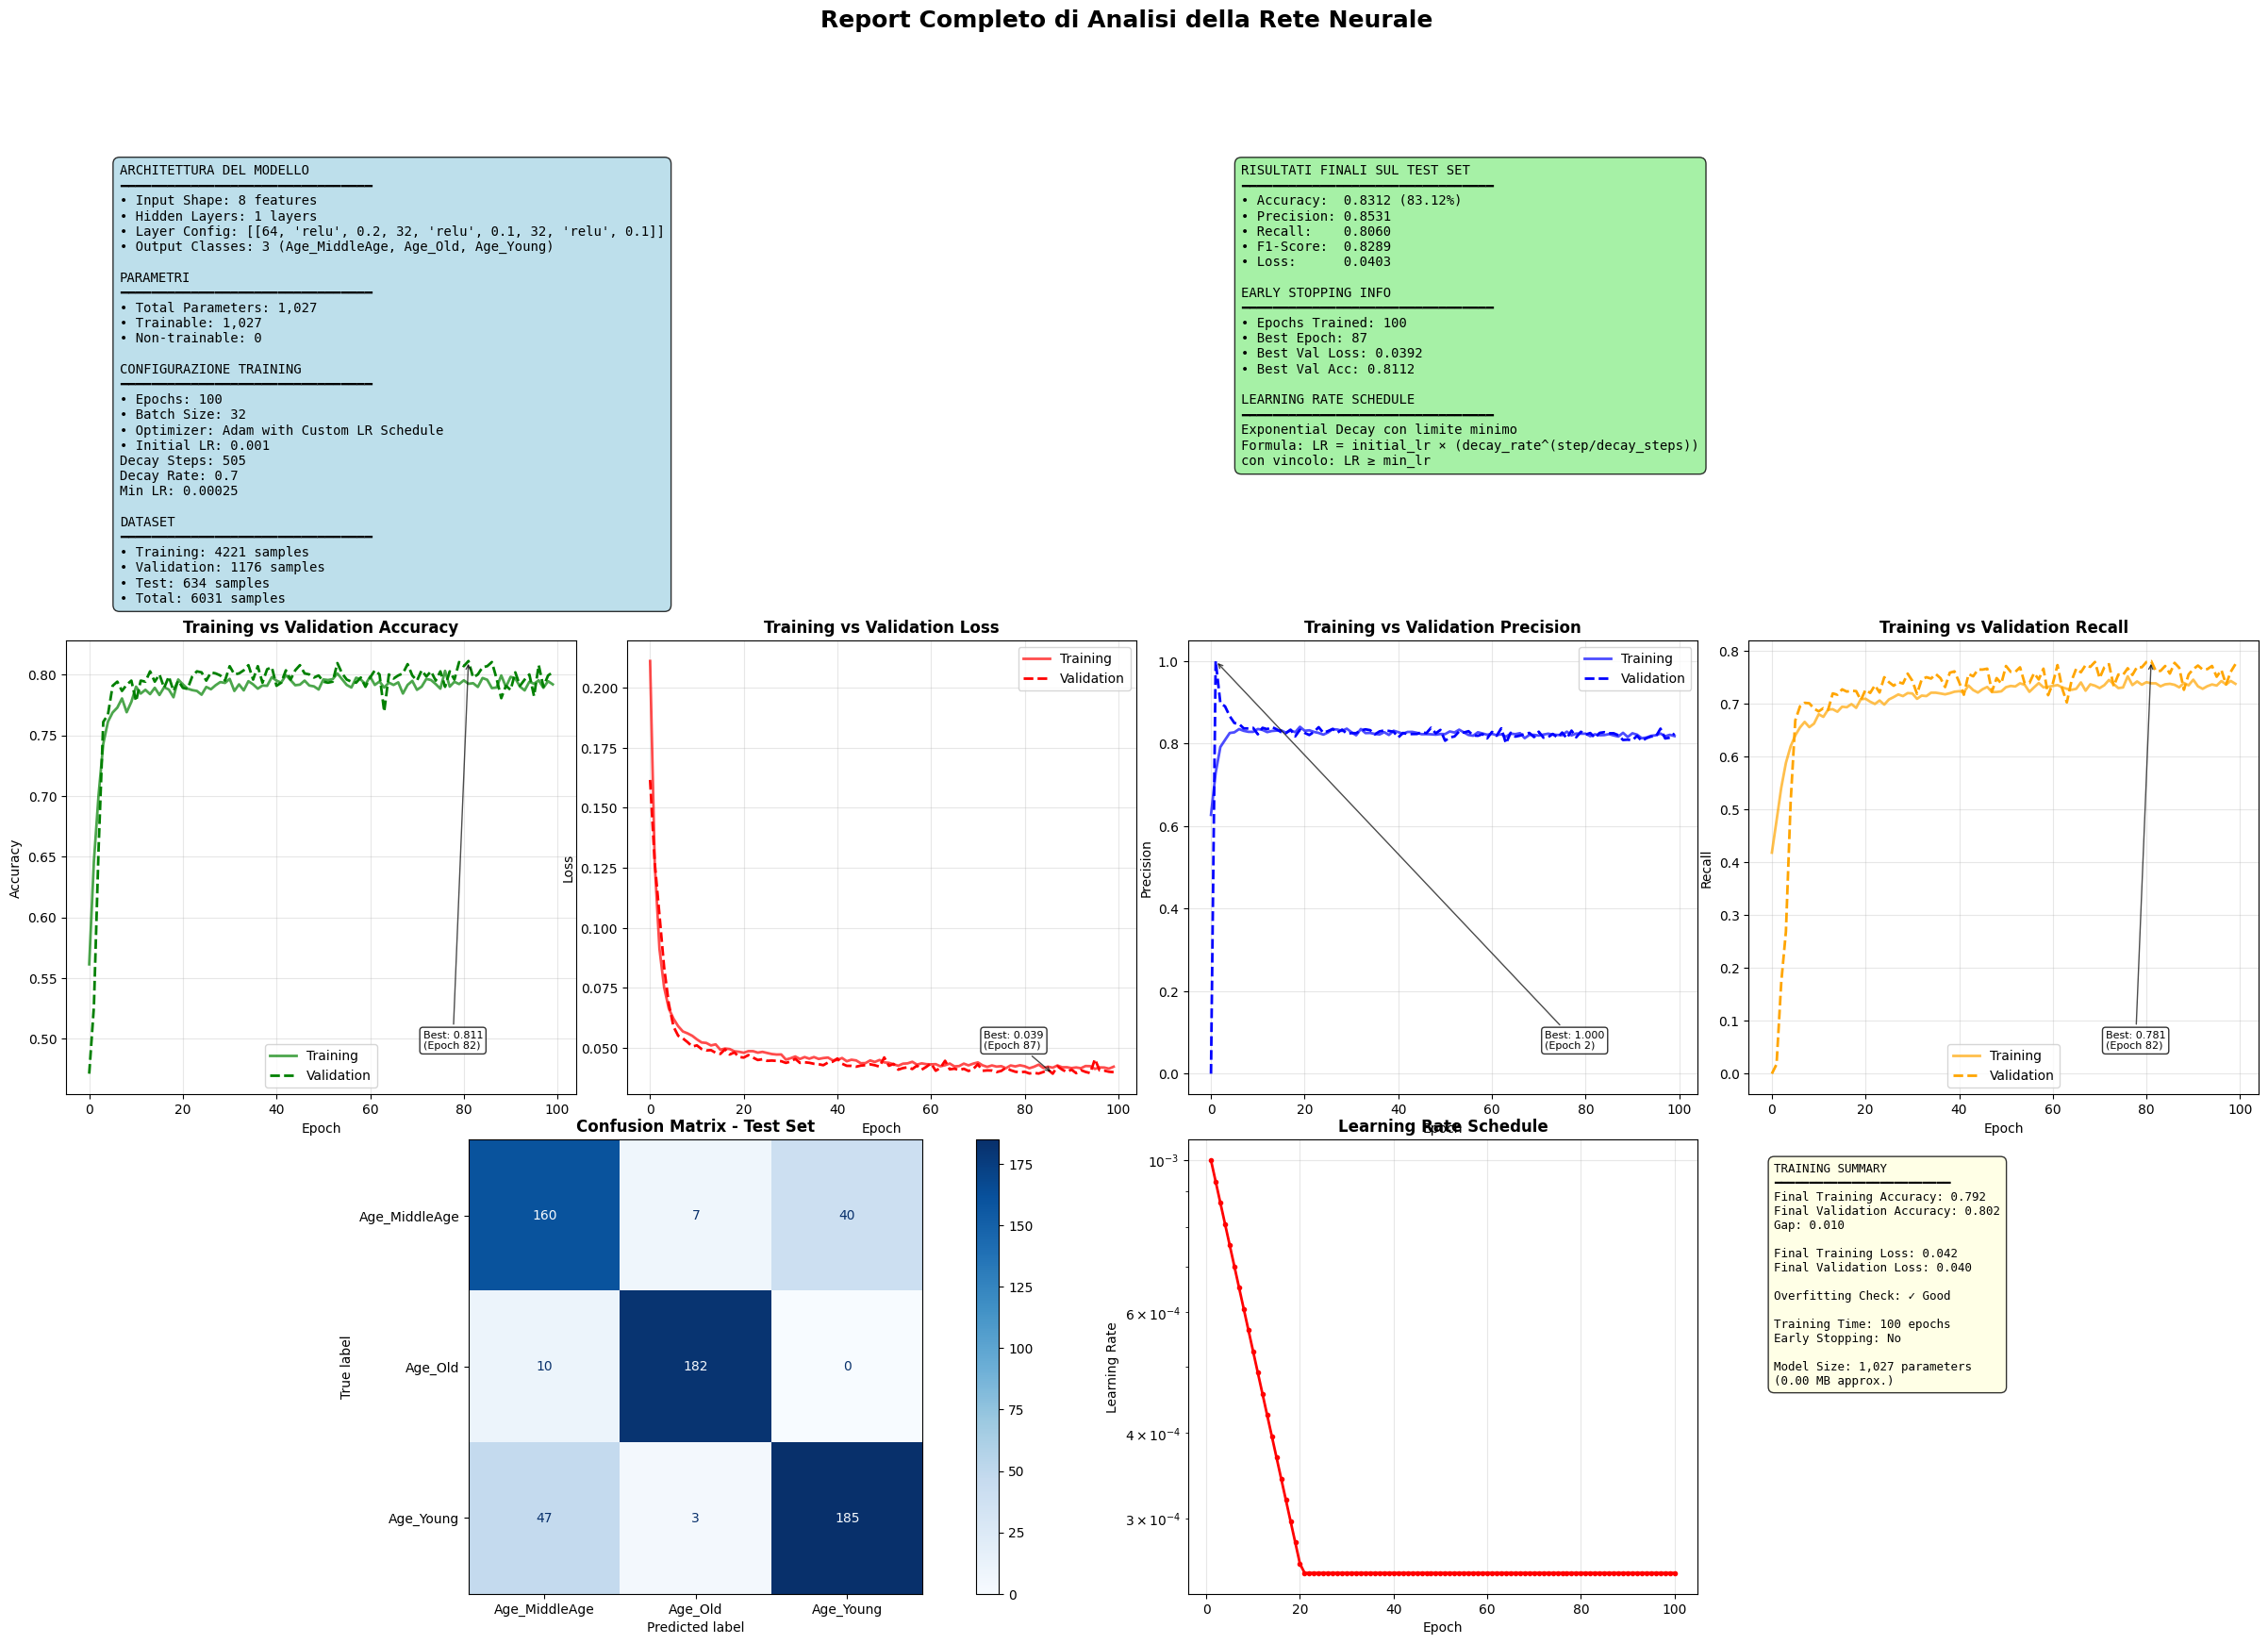

In [240]:
eval = model.evaluate(X_test, Y_test, return_dict = True)

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis = 1)
y_true_classes = np.argmax(Y_test.values, axis = 1)
cm = confusion_matrix(y_true_classes, y_pred_classes)

print("Test set evaluation:")
print(f"Precision: {eval['Precision']:.4f}")
print(f"Recall:    {eval['Recall']:.4f}")
print(f"Loss:      {eval['loss']:.4f}")
print(f"Accuracy:  {eval['accuracy']:.4f}")
print(f"F1-score:  {2 * (eval['Precision'] * eval['Recall']) / (eval['Precision'] + eval['Recall']):.4f}")

# Funzione per creare visualizzazione completa
def create_comprehensive_visualization(model, history, eval_results, cm, Y, lr_schedule, net_layers, num_epochs, batch_size, X_train, X_val, X_test):
    """
    Crea una visualizzazione completa con informazioni del modello, statistiche di training e confusion matrix
    """
    # Configurazione figura con layout personalizzato
    fig = plt.figure(figsize=(30, 20))
    gs = fig.add_gridspec(3, 4, hspace=0.1, wspace=0.1)
    
    # Titolo principale
    fig.suptitle('Report Completo di Analisi della Rete Neurale', fontsize=18, fontweight='bold', y=0.95)
    
    # 1. Informazioni sull'architettura del modello (in alto a sinistra)
    ax_info = fig.add_subplot(gs[0, :2])
    ax_info.axis('off')
    
    # Calcolo parametri del modello
    total_params = model.count_params()
    trainable_params = sum([layer.count_params() for layer in model.layers if layer.trainable])
    non_trainable_params = total_params - trainable_params
    
    # Informazioni sul learning rate
    lr_info = f"Initial LR: {lr_schedule.initial_lr}\nDecay Steps: {lr_schedule.decay_steps}\nDecay Rate: {lr_schedule.decay_rate}\nMin LR: {lr_schedule.min_lr}"
    
    # Testo delle informazioni del modello
    model_info = f"""ARCHITETTURA DEL MODELLO
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
• Input Shape: {X_train.shape[1]} features
• Hidden Layers: {len(net_layers)} layers
• Layer Config: {net_layers}
• Output Classes: {Y.shape[1]} ({', '.join(Y.columns)})

PARAMETRI
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
• Total Parameters: {total_params:,}
• Trainable: {trainable_params:,}
• Non-trainable: {non_trainable_params:,}

CONFIGURAZIONE TRAINING
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
• Epochs: {num_epochs}
• Batch Size: {batch_size}
• Optimizer: Adam with Custom LR Schedule
• {lr_info}

DATASET
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
• Training: {X_train.shape[0]} samples
• Validation: {X_val.shape[0]} samples  
• Test: {X_test.shape[0]} samples
• Total: {X_train.shape[0] + X_val.shape[0] + X_test.shape[0]} samples"""
    
    ax_info.text(0.05, 0.95, model_info, transform=ax_info.transAxes, fontsize=10, 
                verticalalignment='top', fontfamily='monospace',
                bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.8))
    
    # 2. Metriche finali (in alto a destra)
    ax_metrics = fig.add_subplot(gs[0, 2:])
    ax_metrics.axis('off')
    
    f1_score = 2 * (eval_results['Precision'] * eval_results['Recall']) / (eval_results['Precision'] + eval_results['Recall'])
    
    metrics_text = f"""RISULTATI FINALI SUL TEST SET
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
• Accuracy:  {eval_results['accuracy']:.4f} ({eval_results['accuracy']*100:.2f}%)
• Precision: {eval_results['Precision']:.4f}
• Recall:    {eval_results['Recall']:.4f}
• F1-Score:  {f1_score:.4f}
• Loss:      {eval_results['loss']:.4f}

EARLY STOPPING INFO
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
• Epochs Trained: {len(history.history['loss'])}
• Best Epoch: {np.argmin(history.history['val_loss']) + 1}
• Best Val Loss: {min(history.history['val_loss']):.4f}
• Best Val Acc: {max(history.history['val_accuracy']):.4f}

LEARNING RATE SCHEDULE
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Exponential Decay con limite minimo
Formula: LR = initial_lr × (decay_rate^(step/decay_steps))
con vincolo: LR ≥ min_lr"""
    
    ax_metrics.text(0.05, 0.95, metrics_text, transform=ax_metrics.transAxes, fontsize=10, 
                   verticalalignment='top', fontfamily='monospace',
                   bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgreen", alpha=0.8))
    
    # 3-6. Grafici delle metriche di training (riga centrale)
    metrics = [
        ('accuracy', 'val_accuracy', 'Accuracy', 'green'),
        ('loss', 'val_loss', 'Loss', 'red'),
        ('Precision', 'val_Precision', 'Precision', 'blue'),
        ('Recall', 'val_Recall', 'Recall', 'orange')
    ]
    
    for i, (train_metric, val_metric, title, color) in enumerate(metrics):
        ax = fig.add_subplot(gs[1, i])
        ax.plot(history.history[train_metric], label='Training', color=color, alpha=0.7, linewidth=2)
        ax.plot(history.history[val_metric], label='Validation', color=color, linestyle='--', linewidth=2)
        ax.set_title(f'Training vs Validation {title}', fontweight='bold')
        ax.set_xlabel('Epoch')
        ax.set_ylabel(title)
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Aggiungi annotazione per il valore migliore
        if 'loss' in train_metric.lower():
            best_epoch = np.argmin(history.history[val_metric])
            best_value = min(history.history[val_metric])
        else:
            best_epoch = np.argmax(history.history[val_metric])
            best_value = max(history.history[val_metric])
        
        ax.annotate(f'Best: {best_value:.3f}\n(Epoch {best_epoch+1})', 
                   xy=(best_epoch, best_value), xytext=(0.7, 0.1),
                   textcoords='axes fraction', fontsize=8,
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
                   arrowprops=dict(arrowstyle='->', color='black', alpha=0.7))
    
    # 7. Confusion Matrix (in basso a sinistra)
    ax_cm = fig.add_subplot(gs[2, :2])
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=Y.columns)
    cm_display.plot(ax=ax_cm, cmap='Blues', values_format='d')
    ax_cm.set_title('Confusion Matrix - Test Set', fontweight='bold')
    
    # 8. Learning Rate Schedule Visualization (in basso al centro)
    ax_lr = fig.add_subplot(gs[2, 2])
    
    # Simula l'evoluzione del learning rate
    steps = np.arange(0, len(history.history['loss']) * 101, 101)  # 101 step per epoca
    lr_values = [float(lr_schedule(step)) for step in steps]
    epochs_lr = np.arange(1, len(lr_values) + 1)
    
    ax_lr.plot(epochs_lr, lr_values, 'r-', linewidth=2, marker='o', markersize=3)
    ax_lr.set_title('Learning Rate Schedule', fontweight='bold')
    ax_lr.set_xlabel('Epoch')
    ax_lr.set_ylabel('Learning Rate')
    ax_lr.set_yscale('log')
    ax_lr.grid(True, alpha=0.3)
    
    # 9. Training Summary (in basso a destra)
    ax_summary = fig.add_subplot(gs[2, 3])
    ax_summary.axis('off')
    
    # Calcola statistiche riassuntive
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]
    
    overfitting_indicator = "✓ Good" if abs(final_train_acc - final_val_acc) < 0.05 else "⚠ Possible Overfitting"
    
    summary_text = f"""TRAINING SUMMARY
━━━━━━━━━━━━━━━━━━━━━━━━━
Final Training Accuracy: {final_train_acc:.3f}
Final Validation Accuracy: {final_val_acc:.3f}
Gap: {abs(final_train_acc - final_val_acc):.3f}

Final Training Loss: {final_train_loss:.3f}
Final Validation Loss: {final_val_loss:.3f}

Overfitting Check: {overfitting_indicator}

Training Time: {len(history.history['loss'])} epochs
Early Stopping: {'Yes' if len(history.history['loss']) < num_epochs else 'No'}

Model Size: {total_params:,} parameters
({total_params * 4 / 1024 / 1024:.2f} MB approx.)"""
    
    ax_summary.text(0.05, 0.95, summary_text, transform=ax_summary.transAxes, fontsize=9, 
                   verticalalignment='top', fontfamily='monospace',
                   bbox=dict(boxstyle="round,pad=0.5", facecolor="lightyellow", alpha=0.8))
    
    plt.tight_layout()
    return fig

# Chiamata della funzione di visualizzazione completa
fig = create_comprehensive_visualization(
    model=model,
    history=history, 
    eval_results=eval,
    cm=cm,
    Y=Y,
    lr_schedule=lr_schedule,
    net_layers=net_layers,
    num_epochs=num_epochs,
    batch_size=batch_size,
    X_train=X_train,
    X_val=X_val,
    X_test=X_test
)

plt.show()